In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

In [3]:
###mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the stock price data

In [4]:
stock_df= pd.read_csv('./drive/My Drive/Colab Notebooks/GME_stock.csv',parse_dates=["date"])

In [5]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666


In [6]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


The data has inverted order by date. We need to change it in  date ascending order.

In [7]:
stock_df=stock_df.sort_values(by="date", ascending=True)
stock_df.reset_index(inplace=True)
stock_df.set_index('date',inplace=True)

In [8]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838


In [9]:
def create_lag_feature(df,orig_feature,lag):
  new_df=df.copy()
  new_feature_name= "%s_lag%d" %(orig_feature, lag)
  new_df[new_feature_name]=np.nan
  new_df.loc[df.index[lag:],new_feature_name]=df.iloc[:-lag][orig_feature].values
  return new_df

In [10]:
def create_after_days_target(df,orig_column,days_after):
  new_df= df.copy()
  target_column='%s_after_%d_days'%(orig_column, days_after)
  if days_after==1:
    target_column=orig_column +"_tomorrow"
  new_df[target_column]=np.nan
  new_df.loc[df.index[:-days_after],target_column]=df.iloc[days_after:][orig_column].values
  return new_df

In [11]:
stock_df=create_lag_feature(stock_df,'close_price',1) ## add feture: yesterday close_price

In [12]:
stock_df=create_lag_feature(stock_df,'close_price',2) ## add feture: close_price of 2 days before 

In [13]:
stock_df=create_lag_feature(stock_df,'close_price',3)  ## add feture: close_price of 3 days before 

In [14]:
#stock_df=create_lag_feature(stock_df,'close_price',4)  ## add feture: close_price of 4 days before

In [15]:
## create target column "close_price_tomorrow"
stock_df=create_after_days_target(stock_df,'close_price',1)

In [16]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_tomorrow
date,,,,,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666,NaN,NaN,NaN,10.000
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003,10.05,NaN,NaN,9.950
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336,10.00,10.05,NaN,9.550
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.95,10.00,10.05,9.875
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.55,9.95,10.00,9.850


Split the dataframe into training set and test set


> there are some NaN values when we create new features and target columns. one way is to delete these column. the other way is to use SimpleImputer.
<br> lets just delete them first
<br> TODO, add SimpleImputer in preprocessing pipeline.



In [17]:
X=stock_df.iloc[4:4772,1:-1] ### not include the first 3 row and last raw with NAN values
Y=stock_df.iloc[4:4772,-1:]

In [18]:
# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

In [19]:
X_scaled=scaler_X.fit_transform(X)
Y_scaled=scaler_Y.fit_transform(Y)

In [20]:
X_scaled.shape

(4768, 9)

In [21]:
train_size=ceil(X_scaled.shape[0]*0.8)
train_size

3815

In [22]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_tomorrow
date,,,,,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666,NaN,NaN,NaN,10.000
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003,10.05,NaN,NaN,9.950
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336,10.00,10.05,NaN,9.550
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.95,10.00,10.05,9.875
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.55,9.95,10.00,9.850


In [23]:
dates_training = pd.to_datetime(stock_df.index[4:train_size+4])
dates_test = pd.to_datetime(stock_df.index[train_size+4:-1])

In [24]:
X_train, X_test= X_scaled[:train_size],X_scaled[train_size:]
Y_train, Y_test= Y_scaled[:train_size],Y_scaled[train_size:]

In [25]:
X_train.shape, X_test.shape

((3815, 9), (953, 9))

In [26]:
Y_train.shape, Y_test.shape

((3815, 1), (953, 1))

In [27]:
X_train;

In [28]:
Y_train;

Build the BPNN model

In [29]:
model=Sequential()  
model.add(Dense(32,input_dim=9,kernel_initializer='uniform',activation='relu'))
model.add(Dense(8,kernel_initializer='uniform',activation='relu')) #中间层
model.add(Dense(1,activation='linear'))  ##输出层
model.summary()
#model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=0.01),metrics = ['mse', 'mae']) #编译模型
model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(),metrics = ['mse','mae']) #编译模型
history=model.fit(X_train,
          Y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_test,Y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0375 - val_loss: 9.1192e-04 - val_mse: 9.1192e-04 - val_mae: 0.0076
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 1.5157e-05 - mse: 1.5157e-05 - mae: 0.0027 - val_loss: 8.7120e-04 - val_mse: 8.7120e-04 - val_mae: 0.0065
Epoch 3/100
120/120 [=============

In [49]:
#model.save('/content/drive/MyDrive/BPNN_Model/BPNN_1_model_update3.h5')
model.save('/content/drive/MyDrive/BPNN_Model/BPNN_1_model.h5')

In [31]:
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/BPNN_Model/BPNN_1_model.h5')
# model.summary()

In [32]:
def model_loss(history):
  plt.figure(figsize=(11,7))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show();

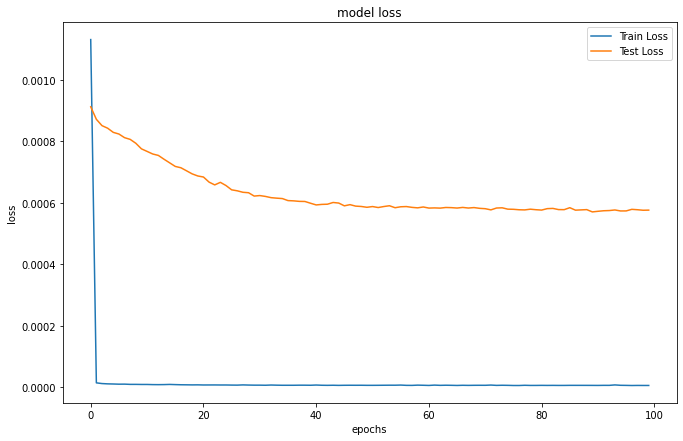

In [33]:
model_loss(history)

In [34]:
y_train_predict = model.predict(X_train)

Use scaler.inverse_transform to convert scaled y value to true price value

In [35]:
def prediction_plot(Y_actual,Y_predict,title,dates):
  plt.figure(figsize=(11,7))
  Y_actual=pd.DataFrame(Y_actual,index=dates)
  Y_predict=pd.DataFrame(Y_predict,index=dates)
  plt.plot(Y_actual,color= 'blue',label='actual')
  plt.plot(Y_predict, color= 'red',label='prediction')
  #plt.tight_layout()
  #sns.despine(top=True)
  #plt.subplots_adjust(left=0.07)
  plt.ylabel('stock_price',size=15)
  plt.xlabel('Date',size=15)
  plt.legend(fontsize=15)
  plt.title('Prediction VS Actual Tomorrow Close Price_'+title+'\n',size=15)
  plt.show()

In [36]:
y_pred_train=scaler_Y.inverse_transform(y_train_predict)
y_actual_train=scaler_Y.inverse_transform(Y_train)

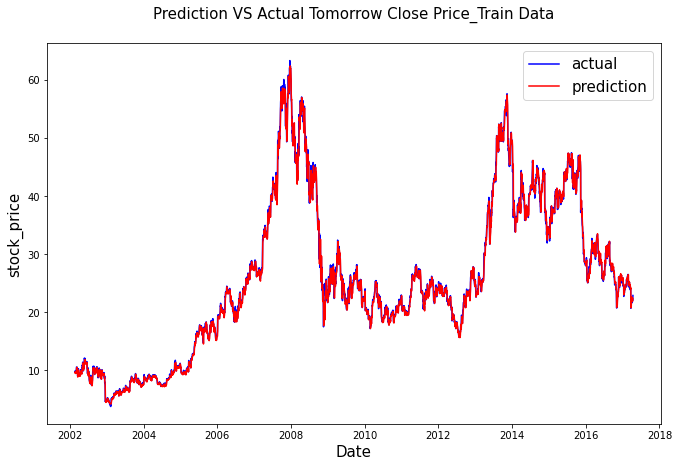

In [37]:
prediction_plot(y_actual_train,y_pred_train,'Train Data',dates_training)

In [38]:
y_test_predict=model.predict(X_test)
y_pred_test=scaler_Y.inverse_transform(y_test_predict)
y_actual_test=scaler_Y.inverse_transform(Y_test)

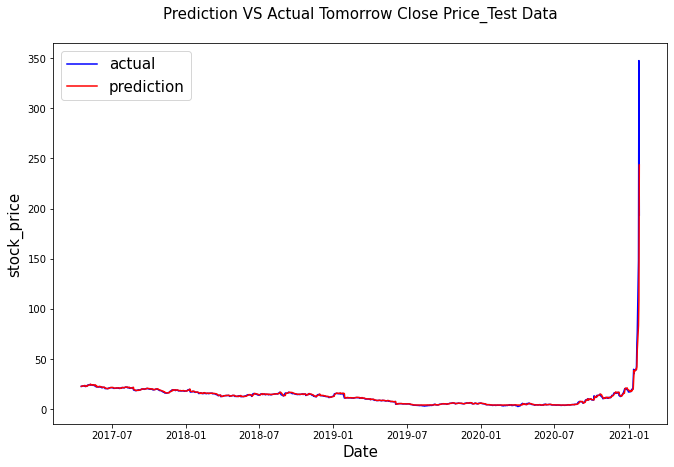

In [39]:
prediction_plot(y_actual_test,y_pred_test,'Test Data',dates_test)

The test set has a unexpected sharp increase in the last 11 days, which would increase the MSE and MAE of test data.

The Three metrics:

In [40]:
RMSE_train = np.sqrt(mean_squared_error(y_actual_train,y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_actual_test,y_pred_test))
print('The root mean square error (RMSE) for the train data is %.4f'%RMSE_train)
print('The root mean square error (RMSE) for the test data is %.4f'%RMSE_test)

The root mean square error (RMSE) for the train data is 0.8169
The root mean square error (RMSE) for the test data is 8.2733


In [41]:
MAE_train = mean_absolute_error(y_actual_train,y_pred_train)
MAE_test = mean_absolute_error(y_actual_test,y_pred_test)
print('The mean absolute error (MAE) for the train data is %.4f'%MAE_train)
print('The mean absolute error (MAE) for the test data is %.4f'%MAE_test)

The mean absolute error (MAE) for the train data is 0.5324
The mean absolute error (MAE) for the test data is 0.8041


In [42]:
R2_train = r2_score(y_actual_train,y_pred_train)
R2_test = r2_score(y_actual_test,y_pred_test)
print('The coefficient of determination (R^2) for the train data is %.4f'% R2_train)
print('The coefficient of determination (R^2) for the test data is %.4f'% R2_test)

The coefficient of determination (R^2) for the train data is 0.9962
The coefficient of determination (R^2) for the test data is 0.6887


In [43]:
y_var_test=y_actual_test[1:]-y_actual_test[:len(y_actual_test)-1]
y_var_predict=y_pred_test[1:]-y_pred_test[:len(y_pred_test)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('up and down direction accuracy: %.4f'%result)

up and down direction accuracy: 0.4779


**Remove the last 11 data (they are increased suddenly)**

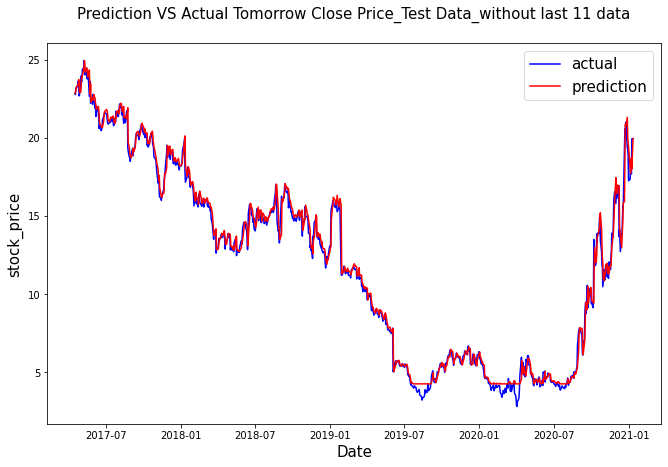

In [44]:
prediction_plot(y_actual_test[:-11],y_pred_test[:-11],'Test Data_without last 11 data',dates_test[:-11])

In [45]:
RMSE_test = np.sqrt(mean_squared_error(y_actual_test[:-11],y_pred_test[:-11]))
print('The root mean square error (RMSE) for the test data(without last 11 data) is %.4f'%RMSE_test)

The root mean square error (RMSE) for the test data(without last 11 data) is 0.5573


In [46]:
MAE_test = mean_absolute_error(y_actual_test[:-11],y_pred_test[:-11])
print('The mean absolute error (MAE) for the test data(without last 11 data) is %.4f'%MAE_test)

The mean absolute error (MAE) for the test data(without last 11 data) is 0.3613


In [47]:
R2_test = r2_score(y_actual_test[:-11],y_pred_test[:-11])
print('The coefficient of determination (R^2) for the test data(without last 11 data) is %.4f'% R2_test)

The coefficient of determination (R^2) for the test data(without last 11 data) is 0.9917


In [48]:
y_actual_test_sub=y_actual_test[:-11]
y_pred_test_sub=y_pred_test[:-11]
y_var_test=y_actual_test_sub[1:]-y_actual_test_sub[:len(y_actual_test_sub)-1]
y_var_predict=y_pred_test_sub[1:]-y_pred_test_sub[:len(y_pred_test_sub)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('up and down direction accuracy(without last 11 data): %.4f'%result)

up and down direction accuracy(without last 11 data): 0.4761
